Sam Arnts

In this notebook I will be experimenting with many time series methods to see which produce the best results for a specific application. The data is from a kaggle competition found at https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview. The goal is to predict the sales for different stores and families of items for a two week period after the given data stops. 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Visualization

In [22]:
#first I will start with visualizing the data

#as we can see, the original training data contains a date, store number, product family, sales numbers
#and a boolean indicating whether there is a promotion or not

In [23]:
train = pd.read_csv("train.csv")
train = train.set_index("id")
train['date'] = pd.to_datetime(train['date'])
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


<AxesSubplot:title={'center':'Total Unit Sales'}, xlabel='date', ylabel='Units'>

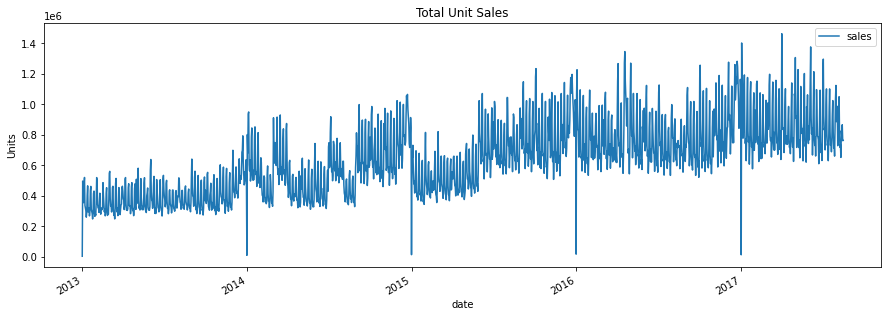

In [24]:
#visualizing total sales by date

color_pal = sns.color_palette()

train_total_sales = train.drop(columns=["store_nbr", "onpromotion", "family"])
train_total_sales = train_total_sales.groupby(['date']).sum()
train_total_sales.plot(kind="line", figsize=(15, 5), color=color_pal[0], title="Total Unit Sales", ylabel="Units")


c:\Users\samue\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


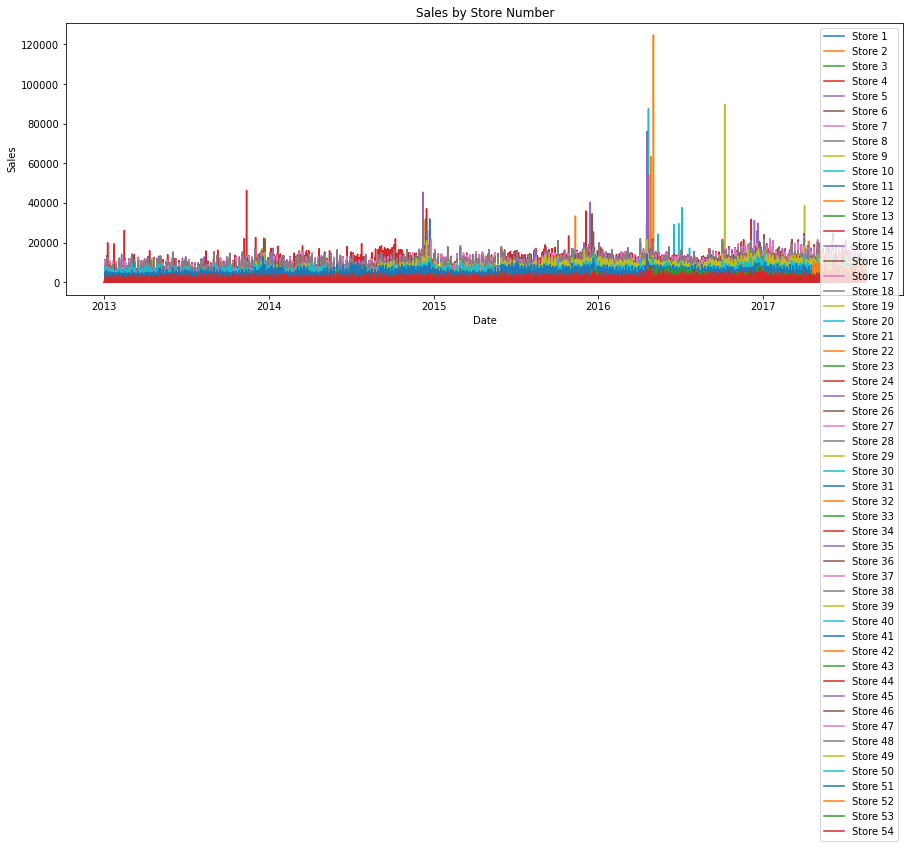

In [25]:
#visualizing sales by date and store number

train_by_store = train.drop(columns=["onpromotion", "family"])

# Group the data by store number
grouped_data = train_by_store.groupby('store_nbr')


fig, ax = plt.subplots(figsize=(15, 5))

# Iterate over each group and plot the sales data
for store_nbr, group in grouped_data:
    ax.plot(group['date'], group['sales'], label=f"Store {store_nbr}")

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales by Store Number')
ax.legend()
plt.show()

Feature Engineering

In [26]:
#now that we've visualized the data, we can start with our feature extraction

In [27]:
#first we want to make sure we can account for whether or not a date is a holdiay
holidays = pd.read_csv("holidays_events.csv")
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [28]:
#dropping holidays that are transferred and holidays that are listed as work days (see data description on kaggle)
# adding is_holiday column for later
holidays = holidays[holidays.transferred == False]
holidays = holidays[holidays.type != "Work Day"]
is_holiday = [True] * len(holidays)
holidays["is_holiday"] = is_holiday
holidays

,date,type,locale,locale_name,description,transferred,is_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,True
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,True
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,True
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,True
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,True
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,True
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,True
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,True
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,True


In [29]:
#merging the train data with the holiday_boolean
train_merge = train.merge(holidays, on="date", how="left")
train_merge = train_merge.fillna(value = False)
train_merge = train_merge.drop(columns=["type", "locale", "locale_name", "description", "transferred"])
train = train_merge

In [30]:
train.head()

,date,store_nbr,family,sales,onpromotion,is_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,True
1,2013-01-01,1,BABY CARE,0.0,0,True
2,2013-01-01,1,BEAUTY,0.0,0,True
3,2013-01-01,1,BEVERAGES,0.0,0,True
4,2013-01-01,1,BOOKS,0.0,0,True


In [31]:
#converting all the data to be numerical
temp_holiday = train["is_holiday"].to_numpy().astype(int)

#this family dict we can use later for the test data
family = train["family"].to_numpy()
family_dict = {}
count = 0
for i in range(len(family)):
    if family[i] not in family_dict:
        family_dict[family[i]] = count
        count += 1

for i in range(len(family)):
    family[i] = family_dict.get(family[i])     


train["family"] = family
train["family"] = train["family"].astype('int')
train["is_holiday"] = temp_holiday
train.dtypes

date           datetime64[ns]
store_nbr               int64
family                  int32
sales                 float64
onpromotion             int64
is_holiday              int32
dtype: object

In [32]:
#lets continue our feature engineering by adding calendar data

def create_calendar_features (df):

    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear

    return df

train = create_calendar_features(train)
train

,date,store_nbr,family,sales,onpromotion,is_holiday,dayofweek,quarter,month,year,dayofyear
0,2013-01-01,1,0,0.000,0,1,1,1,1,2013,1
1,2013-01-01,1,1,0.000,0,1,1,1,1,2013,1
2,2013-01-01,1,2,0.000,0,1,1,1,1,2013,1
3,2013-01-01,1,3,0.000,0,1,1,1,1,2013,1
4,2013-01-01,1,4,0.000,0,1,1,1,1,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
3052561,2017-08-15,9,28,438.133,0,1,1,3,8,2017,227
3052562,2017-08-15,9,29,154.553,1,1,1,3,8,2017,227
3052563,2017-08-15,9,30,2419.729,148,1,1,3,8,2017,227
3052564,2017-08-15,9,31,121.000,8,1,1,3,8,2017,227


In [33]:
#the last feature I want to incorporate is the oil price

oil = pd.read_csv("oil.csv")
oil['date'] = pd.to_datetime(oil['date'])
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [34]:
# mering the oil df to our training df
train = train.merge(oil, how="left")
train

,date,store_nbr,family,sales,onpromotion,is_holiday,dayofweek,quarter,month,year,dayofyear,dcoilwtico
0,2013-01-01,1,0,0.000,0,1,1,1,1,2013,1,NaN
1,2013-01-01,1,1,0.000,0,1,1,1,1,2013,1,NaN
2,2013-01-01,1,2,0.000,0,1,1,1,1,2013,1,NaN
3,2013-01-01,1,3,0.000,0,1,1,1,1,2013,1,NaN
4,2013-01-01,1,4,0.000,0,1,1,1,1,2013,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3052561,2017-08-15,9,28,438.133,0,1,1,3,8,2017,227,47.57
3052562,2017-08-15,9,29,154.553,1,1,1,3,8,2017,227,47.57
3052563,2017-08-15,9,30,2419.729,148,1,1,3,8,2017,227,47.57
3052564,2017-08-15,9,31,121.000,8,1,1,3,8,2017,227,47.57


In [35]:
#making sure every date has a value associated with it
oil_price = train["dcoilwtico"].to_numpy()
new_price = []

#if a value is nan, replace nan with the most recent non nan value
last_val = 93.14
for i in range(len(oil_price)):
    if np.isnan(oil_price[i]):
        new_price.append(last_val)
    else:
        new_price.append(oil_price[i])
        last_val = oil_price[i]  
    

In [36]:
train['oil_price'] = new_price

Model Creation

In [37]:
# now we can create our models

# first we create a train and a test set to test our models. Because this is time series we don't shuffle the data
FEATURES = ['store_nbr', 'family', 'onpromotion', 'is_holiday', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'oil_price']
TARGET = ['sales']

X = train[FEATURES]
y = train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [18]:
# first trying using xgboost

# parameter tuning using grid search cross validation

gsc_xgb = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid={    "learning_rate": (0.05, 0.1, 0.15),
                        "max_depth" : [3, 5, 7],
                        "n_estimators": [100, 500, 1000]},
        scoring = "neg_root_mean_squared_error", verbose=2, cv=2
)

xgb_result = MultiOutputRegressor(gsc_xgb).fit(X_train, y_train)
xgb_result.estimators_[0].best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  11.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  10.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=  54.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=  52.8s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time= 1.8min
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time= 1.7min
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  17.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  16.9s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time= 1.4min
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time= 1.4min
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=1000; total time= 2.9min
[CV] END .learning_rate=0.05, max_depth=5, n_est

{'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 500}

In [19]:
# repeat the same process but with ada boost

gsc_ada = GridSearchCV(
        estimator = AdaBoostRegressor(),
        param_grid={    "learning_rate": (0.1, 5, 10),
                        "loss" : ['linear', 'square', 'exponential'],
                        "n_estimators": [10, 25, 50]            
        },
        scoring = "neg_root_mean_squared_error", verbose=2, cv=2
) 


ada_result = gsc_ada.fit(X_train, y_train.values.ravel())
ada_result.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=10; total time=  27.6s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=10; total time=  26.9s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=25; total time= 1.1min
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=25; total time= 1.1min
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time= 2.4min
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time= 2.3min
[CV] END ....learning_rate=0.1, loss=square, n_estimators=10; total time=  29.3s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=10; total time=  30.2s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=25; total time= 1.2min
[CV] END ....learning_rate=0.1, loss=square, n_estimators=25; total time= 1.1min
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time= 2.1min
[CV] END ....learning_rate=0.1, loss=square, n_e

{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 25}

In [20]:
# repeat the same process but with support vector machines

gsc_rf = GridSearchCV(
        estimator = RandomForestRegressor(),
        param_grid={    "max_depth": (3, 5, 7), 
                        "n_estimators": [50, 100, 150]            
        },
        scoring = "neg_root_mean_squared_error", verbose=2, cv=2
) 


rf_result = gsc_rf.fit(X_train, y_train.values.ravel())
rf_result.best_params_

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=  35.6s
[CV] END .......................max_depth=3, n_estimators=50; total time=  34.6s
[CV] END ......................max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ......................max_depth=3, n_estimators=100; total time= 1.2min
[CV] END ......................max_depth=3, n_estimators=150; total time= 1.8min
[CV] END ......................max_depth=3, n_estimators=150; total time= 1.7min
[CV] END .......................max_depth=5, n_estimators=50; total time= 1.0min
[CV] END .......................max_depth=5, n_estimators=50; total time=  58.7s
[CV] END ......................max_depth=5, n_estimators=100; total time= 2.0min
[CV] END ......................max_depth=5, n_estimators=100; total time= 2.0min
[CV] END ......................max_depth=5, n_estimators=150; total time= 2.9min
[CV] END ......................max_depth=5, n_est

{'max_depth': 7, 'n_estimators': 150}

In [38]:
# now lets fit our models with our train split. Using our test split we can compare performance of the models

In [46]:
#xgboost

xgb_model = xgb.XGBRegressor(learning_rate = 0.15, max_depth = 7, n_estimators = 500)

xgb_model.fit(X_train, y_train)

mean_squared_error(y_test, xgb_model.predict(X_test))

222282.02161316236

In [47]:
#adaboost

ada_model = AdaBoostRegressor(learning_rate= 0.1, loss = 'exponential', n_estimators = 25)

ada_model.fit(X_train, y_train.values.ravel())

mean_squared_error(y_test.values.ravel(), ada_model.predict(X_test))

1089865.4597429654

In [48]:
#radomforest

rf_model = RandomForestRegressor(max_depth = 7, n_estimators = 150)

rf_model.fit(X_train, y_train.values.ravel())

mean_squared_error(y_test.values.ravel(), rf_model.predict(X_test))

439138.67716345395